# Insider Threat Detection with LSTM

This notebook trains an LSTM model using our custom reverse-mode automatic differentiation library for insider threat detection based on user behavior analysis.

In [1]:
import sys
import numpy as np
sys.path.append('..')

import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import torch

from lib.reverse_auto_diff import Tensor, LSTM, Linear, sigmoid_d, log_d, exp_d
from lib.optim import SGD, Adam, RMSProp, AdamW, LRSchedulerOnPlateau

In [2]:
# Set device for lib
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

import lib.reverse_auto_diff
lib.reverse_auto_diff.device = device

Using device: cuda


In [3]:
# Define the model
class LSTMClassifier:
    def __init__(self, input_size, hidden_size, output_size):
        self.lstm = LSTM(input_size, hidden_size)
        self.linear = Linear(hidden_size, output_size)

    def parameters(self):
        return self.lstm.parameters() + self.linear.parameters()

    def forward(self, x_seq):
        h = self.lstm.forward([Tensor(x) for x in x_seq])
        out = self.linear.forward(h)
        return sigmoid_d(out)

    def forward_batch(self, x_batch):
      # x_batch: numpy array, torch tensor or list -> shape (B, T, F)
        if isinstance(x_batch, np.ndarray):
            x_batch = torch.tensor(x_batch, device=device, dtype=torch.float32)
        elif isinstance(x_batch, list):
            x_batch = torch.tensor(np.array(x_batch), device=device, dtype=torch.float32)
        # x_batch is now a torch.Tensor -> pass directly to lib batched forward
        h = self.lstm.forward_batch(x_batch)   # lib expects (B, T, F) torch tensor
        out = self.linear.forward_batch(h)     # should return lib.Tensor (B,1)
        return sigmoid_d(out)

# Model hyperparameters
input_size = 7  # one-hot encoded activity types (6) + pc normalized (1)
hidden_size = 64
output_size = 1

model = LSTMClassifier(input_size, hidden_size, output_size)

In [4]:
# Loss function: Binary Cross Entropy
def bce_loss(pred, target):
    # pred is sigmoid output, target is 0 or 1
    loss = - (target * log_d(pred) + (1 - target) * log_d(1 - pred))
    return loss

# Training function
def train_model(model, optimizer, X_train, y_train, X_val, y_val, epochs=10, scheduler=None, batch_size=64):
    train_losses, val_losses = [], []
    # convert once to torch tensors on device (we wrap into lib.Tensor inside forward_batch)
    X_train_t = torch.tensor(X_train, device=device, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, device=device, dtype=torch.float32).reshape(-1,1)
    X_val_t = torch.tensor(X_val, device=device, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, device=device, dtype=torch.float32).reshape(-1,1)

    n = len(X_train)
    for epoch in range(epochs):
        perm = np.random.permutation(n)
        epoch_loss = 0.0
        optimizer.zero_grad()
        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            xb = X_train_t[idx]
            yb = y_train_t[idx]
            pred = model.forward_batch(xb)               # lib.Tensor with shape (B,1)
            loss_batch = bce_loss(pred, Tensor(yb))     # returns per-sample Tensor (B,1)
            loss = loss_batch.mean()                    # scalar lib.Tensor
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += float(loss.data.cpu().item()) * len(idx)
        train_losses.append(epoch_loss / n)

        # validation
        val_loss = 0.0
        m = len(X_val)
        for i in range(0, m, batch_size):
            xb = X_val_t[i:i+batch_size]
            yb = y_val_t[i:i+batch_size]
            pred = model.forward_batch(xb)
            loss_batch = bce_loss(pred, Tensor(yb))
            val_loss += float(loss_batch.mean().data.cpu().item()) * xb.shape[0]
        val_losses.append(val_loss / m)

        if scheduler:
            scheduler.step(val_losses[-1])

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}, LR: {optimizer.learning_rate:.6f}")
    return train_losses, val_losses

Data shape: (1000, 100, 7), Labels shape: (1000,)
Train: (700, 100, 7), Val: (150, 100, 7), Test: (150, 100, 7)

Training with SGD
Epoch 1/20, Train Loss: 0.687909, Val Loss: 0.681547, LR: 0.010000
Epoch 2/20, Train Loss: 0.677257, Val Loss: 0.671016, LR: 0.010000
Epoch 3/20, Train Loss: 0.667705, Val Loss: 0.661509, LR: 0.010000
Epoch 4/20, Train Loss: 0.659121, Val Loss: 0.652974, LR: 0.010000
Epoch 5/20, Train Loss: 0.651440, Val Loss: 0.645384, LR: 0.010000
Epoch 6/20, Train Loss: 0.644634, Val Loss: 0.638486, LR: 0.010000
Epoch 7/20, Train Loss: 0.638441, Val Loss: 0.632319, LR: 0.010000
Epoch 8/20, Train Loss: 0.632975, Val Loss: 0.626822, LR: 0.010000
Epoch 9/20, Train Loss: 0.628062, Val Loss: 0.621849, LR: 0.010000
Epoch 10/20, Train Loss: 0.623678, Val Loss: 0.617361, LR: 0.010000
Epoch 11/20, Train Loss: 0.619696, Val Loss: 0.613302, LR: 0.010000
Epoch 12/20, Train Loss: 0.616116, Val Loss: 0.609637, LR: 0.010000
Epoch 13/20, Train Loss: 0.612929, Val Loss: 0.606349, LR: 0.0

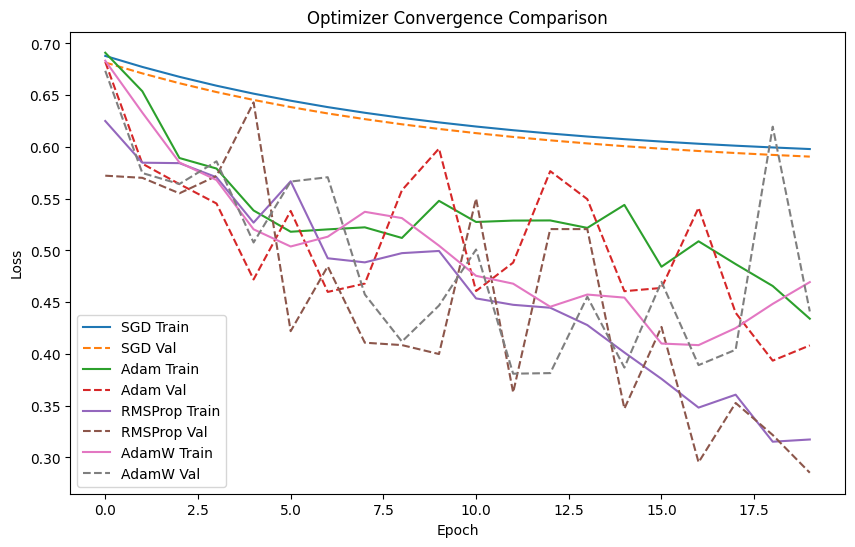

In [5]:
# Load processed data
with open('processed.pkl', 'rb') as f:
    X, y = pickle.load(f)

print(f"Data shape: {X.shape}, Labels shape: {y.shape}")

# Split into train, val, test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Benchmark different optimizers
optimizers = {
    'SGD': SGD(model.parameters(), learning_rate=0.01),
    'Adam': Adam(model.parameters(), learning_rate=0.001),
    'RMSProp': RMSProp(model.parameters(), learning_rate=0.001),
    'AdamW': AdamW(model.parameters(), learning_rate=0.001)
}

results = {}

for name, opt in optimizers.items():
    print(f"\nTraining with {name}")
    # Reset model parameters for fair comparison
    for param in model.parameters():
        param.data = torch.randn(*param.data.shape, device=device) * 0.01

    train_losses, val_losses = train_model(model, opt, X_train, y_train, X_val, y_val, epochs=20, batch_size=32)
    results[name] = (train_losses, val_losses)

# Plot convergence
plt.figure(figsize=(10, 6))
for name, (train_l, val_l) in results.items():
    plt.plot(train_l, label=f'{name} Train')
    plt.plot(val_l, label=f'{name} Val', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Optimizer Convergence Comparison')
plt.show()

In [6]:
# Select best optimizer (lowest final val loss)
best_opt_name = min(results, key=lambda x: results[x][1][-1])
print(f"Best optimizer: {best_opt_name}")

# Retrain with best optimizer on full train + val, then test
X_train_full = np.concatenate([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

# Reset model
for param in model.parameters():
    param.data = torch.randn(*param.data.shape, device=device) * 0.01

best_opt = optimizers[best_opt_name]
scheduler = LRSchedulerOnPlateau(best_opt, initial_lr=best_opt.learning_rate, patience=5, factor=0.5, min_lr=1e-6)

Best optimizer: RMSProp


In [7]:
train_losses, _ = train_model(model, best_opt, X_train_full, y_train_full, X_test, y_test, epochs=50, scheduler=scheduler, batch_size=32)  # Use test as val for now

Epoch 1/50, Train Loss: 0.691853, Val Loss: 0.686938, LR: 0.001000
Epoch 2/50, Train Loss: 0.682844, Val Loss: 0.674954, LR: 0.001000
Epoch 3/50, Train Loss: 0.653671, Val Loss: 0.584799, LR: 0.001000
Epoch 4/50, Train Loss: 0.576496, Val Loss: 0.547063, LR: 0.001000
Epoch 5/50, Train Loss: 0.522593, Val Loss: 0.540134, LR: 0.001000
Epoch 6/50, Train Loss: 0.483522, Val Loss: 0.457902, LR: 0.001000
Epoch 7/50, Train Loss: 0.479893, Val Loss: 0.525599, LR: 0.001000
Epoch 8/50, Train Loss: 0.452761, Val Loss: 0.426752, LR: 0.001000
Epoch 9/50, Train Loss: 0.450968, Val Loss: 0.424696, LR: 0.001000
Epoch 10/50, Train Loss: 0.420125, Val Loss: 0.406299, LR: 0.001000
Epoch 11/50, Train Loss: 0.406164, Val Loss: 0.388565, LR: 0.001000
Epoch 12/50, Train Loss: 0.384315, Val Loss: 0.370481, LR: 0.001000
Epoch 13/50, Train Loss: 0.384630, Val Loss: 0.361754, LR: 0.001000
Epoch 14/50, Train Loss: 0.357528, Val Loss: 0.353041, LR: 0.001000
Epoch 15/50, Train Loss: 0.340765, Val Loss: 0.313067, LR

In [8]:
# Evaluate on test
def evaluate(model, X, y, batch_size=256):
    X_t = torch.tensor(X, device=device, dtype=torch.float32)
    probs = []
    for i in range(0, len(X), batch_size):
        xb = X_t[i:i+batch_size]
        pred = model.forward_batch(xb)             # lib.Tensor (B,1)
        probs.append(pred.data.cpu().numpy().ravel())
    probs = np.concatenate(probs)
    preds = (probs > 0.5).astype(int)
    acc = accuracy_score(y, preds)
    prec = precision_score(y, preds, zero_division=0)
    rec = recall_score(y, preds, zero_division=0)
    f1 = f1_score(y, preds, zero_division=0)
    auc = roc_auc_score(y, probs) if len(np.unique(y)) > 1 else 0
    auprc = average_precision_score(y, probs) if len(np.unique(y)) > 1 else 0
    return acc, prec, rec, f1, auc, auprc

acc, prec, rec, f1, auc, auprc = evaluate(model, X_test, y_test)
print(f"Test Metrics - Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}, AUPRC: {auprc:.4f}")

Test Metrics - Acc: 0.8800, Prec: 0.8000, Rec: 0.7179, F1: 0.7568, AUC: 0.9339, AUPRC: 0.8492


In [10]:
import os, pickle
os.makedirs('models', exist_ok=True)

model_dict = {
    'lstm': [p.data.cpu().numpy() for p in model.lstm.parameters()],
    'linear': [p.data.cpu().numpy() for p in model.linear.parameters()]
}

with open('models/lstm_model_params.pkl', 'wb') as f:
    pickle.dump(model_dict, f)

print("Saved model parameters to models/lstm_model_params.pkl")

Saved model parameters to models/lstm_model_params.pkl
